# Supplementary Figures
This notebook will present analyses and discussions of the GH-VAP project looking for potential microbiome causes/associations with individuals who produce broadly neutralizing antibodies to HIV; as well as everything else I can learn from the transcriptome. 

This specific notebook will handle the code to generate supplementary figures.

## Author: 
 **Mark Kowarsky**
 
 - **Date Updated:** 2018-10-24


#### Code cleaned by:
- Mercedes Dalman
- **Date Updated:** 2025-09

## Imports and stylings

In [1]:
%matplotlib inline
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import HTSeq
import glob
import itertools
from collections import defaultdict
import matplotlib.dates as mdates
from collections import defaultdict


#from wordcloud import WordCloud
from matplotlib.colors import to_hex

from ete3 import NCBITaxa, TreeStyle, NodeStyle, faces

from IPython.core.pylabtools import figsize

from scipy.interpolate import PchipInterpolator
from scipy.stats.mstats import spearmanr

from sklearn import decomposition, manifold

from adjustText import adjust_text


from pathlib import Path
import os, re

import pysam


#%load_ext rpy2.ipython

In [2]:
# Colours from Material Design - https://material.io/tools/color/
green = "#388e3c"
light_green = "#6abf69"
dark_green = "#00600f"

blue = "#1976d2"
light_blue = "#63a4ff"
dark_blue = "#004ba0"

red = "#d32f2f"
light_red = "#ff6659"
dark_red = "#9a0007"

yellow = "#fbc02d"
light_yellow = "#fff263"
dark_yellow = "#c49000"

grey = "#616161"
light_grey = "#8e8e8e"
dark_grey = "#373737"

orange = "#f57c00"
light_orange = "#ffad42"
dark_orange = "#bb4d00"

purple = "#7b1fa2"
dark_purple = "#4a0072"
light_purple = "#ae52d4"

## HIV/AIDS statistics figures

## Breadth of broadly neutralizing antibodies

In [3]:
breadth_metadata = pd.read_excel("../tables/Gates_metadata.xlsx", index_col=[22, 23])
breadth_metadata.index = ["_".join(map(str,x)) for x in breadth_metadata.index]
breadth_metadata["Patient"] = [x.split("_")[0] for x in breadth_metadata.index]
breadth_metadata["sample"] = "SAMPLE_" + breadth_metadata["Patient"] + "_" + breadth_metadata["Years PI"].astype(str)
breadth_metadata.set_index("sample", inplace=True)

In [4]:
def convert_less_than(x):
    if isinstance(x, str) and "<" in x:
        return 0
    else:
        return float(x)

In [5]:
design = pd.read_table("../tables/edgeR_design.txt", index_col=0)

a = list(design.query("bNAbs == 'Y'").index)
b = list(design.query("bNAbs == 'N'").index)
c = a + b

In [6]:
meta1 = pd.read_excel("../tables/Gates_metadata.xlsx", sheet_name=1)
meta1["sample"] = "SAMPLE_" + meta1["PID"].astype(str) + 14*["_1", "_2", "_3"]
meta1.set_index("sample", inplace=True)

## FigureS1 - Clinical Information on Blood Samples


In [7]:
meta2 = pd.read_excel("../tables/Gates_metadata.xlsx", sheet_name=2)
meta2.sort_values(by=["PID", "Specimen Collection Date"], inplace=True)

In [8]:
a = list(design.query("bNAbs == 'Y'").index)[::3]
b = list(design.query("bNAbs == 'N'").index)[::3]
c = a + b
c[::2] = a
c[1::2] = b

In [9]:
def plot_HIV_timeseries(df, ax=None, cd4_color=orange, viralload_color=purple):
    if ax is None:
        ax = plt.gca()
    
    # Extra information from the dataframe
    t = df["Specimen Collection Date"]
    n = df["PID"].iloc[0]
    cd4  = df["CD4 count"]
    vl = df["Viral Load"]
    
    # Find time domain, with month buffers
    infection = df["Date of infection"].iloc[0]
    art = meta1[meta1["PID"] == n]["ART date"].iloc[0]
    start_time = infection
    if art == ".":
        end_time = t.max()
    else:
        end_time = max(t.max(), art)
    T = pd.date_range(t.min(), t.max())
    
    # Plot CD4 counts
    ax.plot(T, PchipInterpolator(t, cd4)(T), linewidth=4, zorder=10, alpha=0.8, color=cd4_color)
    ax.axhspan(ymin=0, ymax=200, color=light_grey, alpha=0.5)
    ax.set_ylim(0, 1200)
    ax.tick_params('y', colors=cd4_color, labelsize=14)
    
    # Plot viral load
    ax2 = ax.twinx()
    ax2.plot(T, PchipInterpolator(t, vl)(T), linewidth=4, zorder=10, alpha=0.8, color=viralload_color)
    ax2.set_ylim(1e2, 1e7)
    ax2.set_yscale("log")
    ax2.tick_params('y', colors=viralload_color, labelsize=14)

    # Plasma times
    for p in meta1[meta1["PID"] == n]["vdate"]:
        s = meta1.loc[meta1[meta1["PID"] == n].query("vdate == '{}'".format(p)).index]
        ax.scatter(p, s["CD4"], zorder=100, marker="D", s=64, color=dark_orange)
        ax2.scatter(p, s["viralload"], zorder=100, marker="D", s=64, color=dark_purple)
    
    # Year ticks
    for y in pd.date_range(start_time, end_time, freq="AS"):
        ax.axvline(y, ymax=0.05, linewidth=1, color='k')
    
    # Extra annotations
    ax.annotate(str(n), xy=(0.5, 1), xycoords="axes fraction",
            ha="center", va="bottom", fontsize=16)
    ax.set_xlim(start_time, end_time)
    sns.despine(right=False)
    ax.set_xticks([])
    ax2.set_xticks([])

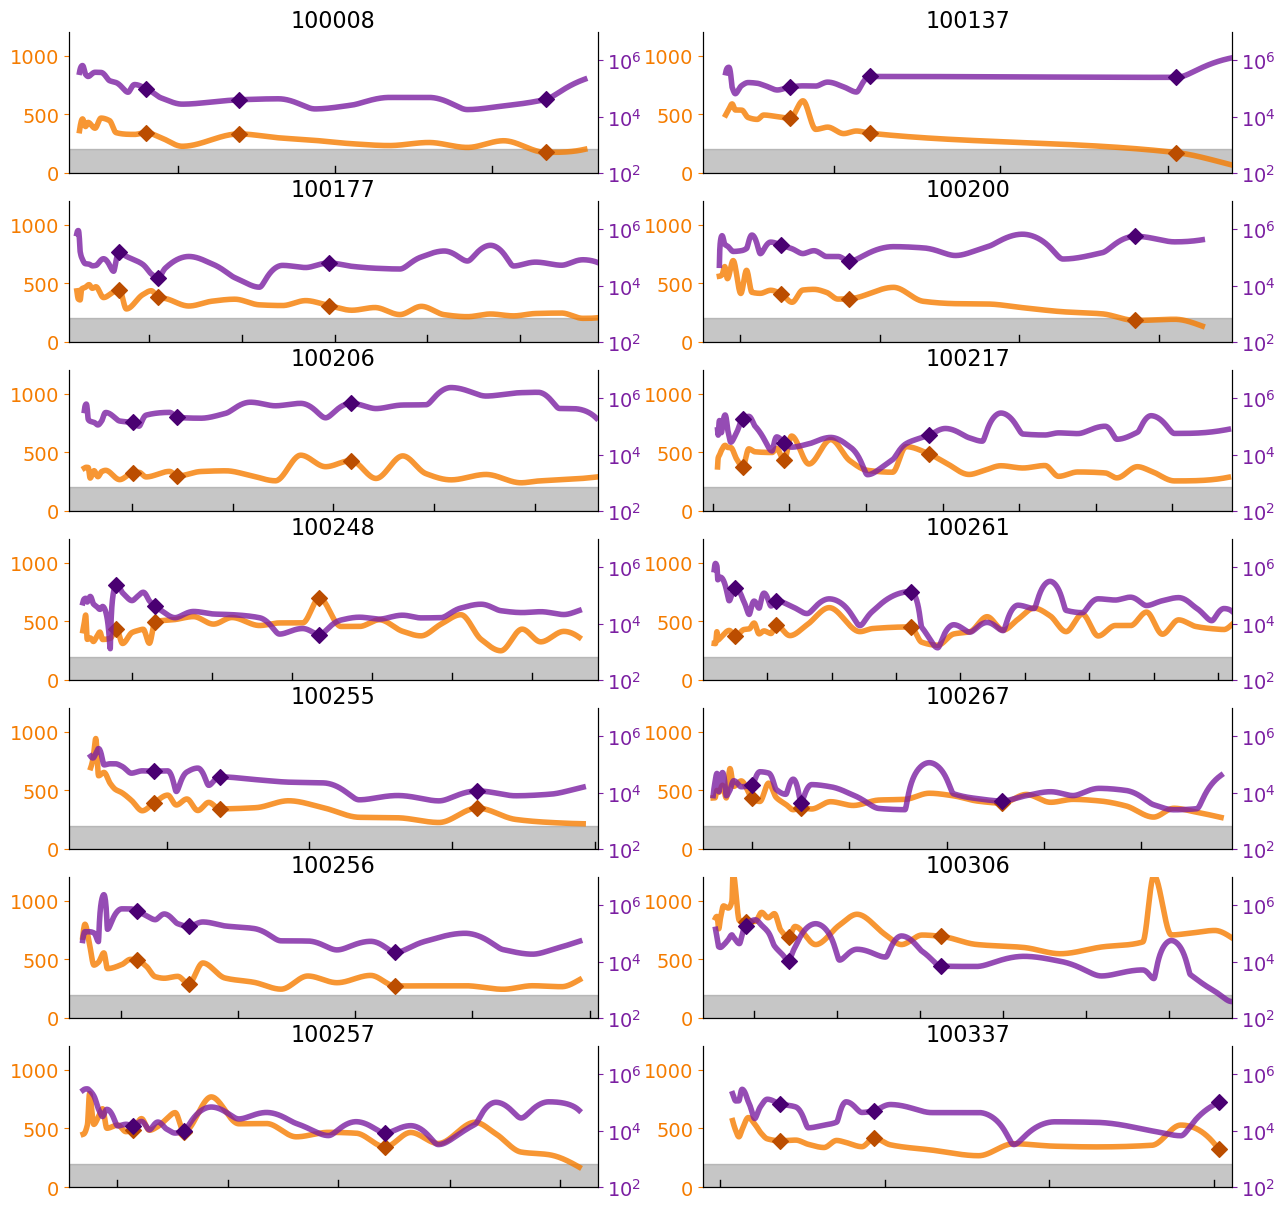

In [10]:
import warnings
warnings.filterwarnings("ignore")


figsize(15, 15)
f, axarr = plt.subplots(nrows=7, ncols=2)

for i, p in enumerate([i.split("_")[1] for i in c]):
    g = meta2.query("PID == {}".format(p)).dropna()
    plot_HIV_timeseries(g, ax=axarr.reshape(-1)[i])
os.makedirs('../figures/sfigures/sfigure1', exist_ok = True)
plt.savefig("../figures/sfigures/sfigure1/s2_time_series.svg")
plt.show()

# Figure S2

## Basic statistics

In [11]:
rsa = pd.read_table("../tables/samples/rSA.csv", index_col=0)
sa = pd.read_table("../tables/samples/SA.csv", index_col=0)

In [12]:
pre = pd.read_table("../tables/preprocess_stats.txt", index_col=0)

pre["group"] = [i.strip("B") if (i.endswith("B") and i != "Water_B") else i for i in pre.index]
pre = pre.groupby("group").sum()

# Non-human counts
nh = pd.read_table("../tables/not_human_stats.txt", names=["sample", "type", "end", "stat"])
nh["type"] = nh["type"] + "_" + nh["end"]
nh = nh.pivot(index="sample", columns="type", values="stat")

nh["group"] = [i.strip("B") if (i.endswith("B") and i != "Water_B") else i for i in nh.index]
nh = nh.groupby("group").sum()

In [13]:
# Order of samples
a = list(design.query("bNAbs == 'Y'").index)
b = list(design.query("bNAbs == 'N'").index)
c = a + b

In [14]:
pre_rsa = pd.DataFrame(index=rsa.index, columns=["raw", "cleaned", "nonhuman"])
pre_rsa.loc[rsa.index, "raw"] = pre.loc[rsa.index, "raw_fastq.1"]
pre_rsa.loc[rsa.index, "cleaned"] = 100-\
                                    100*(pre.loc[rsa.index, ["cleaned_fastq.1", 
                                                             "cleaned_fastq.U"]].sum(axis=1))/pre.loc[rsa.index, 
                                                    ["raw_fastq.1", "raw_fastq.U"]].sum(axis=1)
pre_rsa.loc[rsa.index, "cleaned_counts"] = (pre.loc[rsa.index, ["cleaned_fastq.1", 
                                                             "cleaned_fastq.U"]].sum(axis=1))
pre_rsa.loc[rsa.index, "nonhuman"] = 100*(nh.loc[rsa.index, ["human_genome_fastq.1", 
                                                             "human_genome_fastq.U"]].sum(axis=1))/pre.loc[rsa.index, 
                                                    ["cleaned_fastq.1", "cleaned_fastq.U"]].sum(axis=1)
pre_rsa["human"] = 100 - pre_rsa["nonhuman"]
pre_rsa["human_counts"] = pre_rsa["cleaned_counts"] - nh.loc[rsa.index, ["human_genome_fastq.1", 
                                                             "human_genome_fastq.U"]].sum(axis=1)

pre_rsa = pre_rsa.sort_index()
pre_rsa["Subject"] = [i.split("_")[1] for i in pre_rsa.index]
pre_rsa["Subject"] = [i[:-1] if "water" in i else i for i in pre_rsa["Subject"]]

pre_rsa = pre_rsa.loc[c + list(rsa.index.difference(c))] # Preserve order from before

In [15]:
meta1["other_name"] = meta1["PID"].astype(str) + "_" + meta1["visit code"].astype(str)
meta1["old_name"] = meta1.index
m = meta1.set_index("other_name")

In [16]:
I = sa.index.intersection(pre.index).intersection(nh.index)
pre_sa = pd.DataFrame(index=I, columns=["raw", "cleaned", "nonhuman"])
pre_sa.loc[I, "raw"] = pre.loc[I, "raw_fastq.1"]
pre_sa.loc[I, "cleaned"] = 100-\
                                    100*(pre.loc[I, ["cleaned_fastq.1", 
                                                             "cleaned_fastq.U"]].sum(axis=1))/pre.loc[I, 
                                                    ["raw_fastq.1", "raw_fastq.U"]].sum(axis=1)
pre_sa.loc[I, "cleaned_counts"] = pre.loc[I, ["cleaned_fastq.1", 
                                                             "cleaned_fastq.U"]].sum(axis=1)
    
pre_sa.loc[I, "nonhuman"] = 100*(nh.loc[I, ["human_genome_fastq.1", 
                                                             "human_genome_fastq.U"]].sum(axis=1))/pre.loc[I, 
                                                    ["cleaned_fastq.1", "cleaned_fastq.U"]].sum(axis=1)
pre_sa["human"] = 100 - pre_sa["nonhuman"]

pre_sa.loc["100206_4230"] = np.nan
pre_sa.loc["100306_3090"] = np.nan

pre_sa = pre_sa.sort_index()
pre_sa["Subject"] = [i.split("_")[0] for i in pre_sa.index]
pre_sa.index = [m.loc[i, "old_name"] for i in pre_sa[pre_sa["Subject"] != "Water"].index] + \
  list(pre_sa[pre_sa["Subject"] == "Water"].index)

In [17]:
def plot_stats(data, x,color="k", yscale=None, ylim=None, savefig=None):
    figsize(len(x)/3, 2)
    data = data[data.Subject != 'NTC'].copy()
    x.plot.bar(color=color)
    
    if ylim is not None:
        plt.ylim(*ylim)

    if yscale is not None:
        plt.yscale(yscale)
    
    for i in range(14):
        if (i % 2) == 1:
            plt.axvspan(xmin=i*3-0.5, xmax=(i+1)*3-0.5, zorder=0, color=grey, alpha=0.3)
    
    xlocs = list(np.arange(14)*3+1) + [44.5]
    xticks = list(data["Subject"].unique()) 
    plt.xticks(xlocs, xticks)
    plt.xlabel('')
    sns.despine()
    if savefig is not None:
        plt.savefig(savefig)
    plt.show()

### Panel A

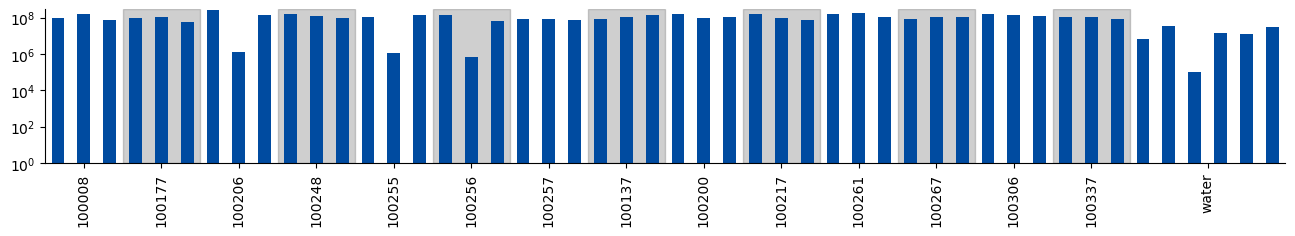

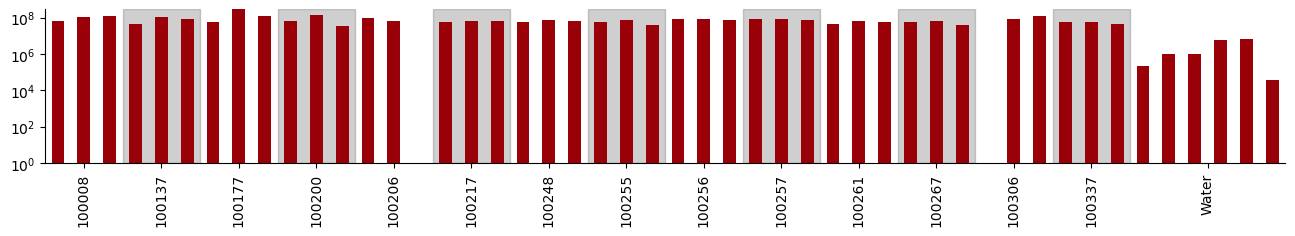

In [21]:
# Rows of bar charts for each sample, aligned to be the same size
r = pre_rsa.query("Subject != 'NTC'")
d = pre_sa

# A: no. sequenced fragments
os.makedirs('../figures/sfigures/sfigure2/panel_A/', exist_ok=True)
plot_stats(r,r["raw"], color=dark_blue, yscale="log", ylim=(1, 3e8), savefig="../figures/sfigures/sfigure2/panel_A/rna_counts.svg")
plot_stats(d,d["raw"], color=dark_red, yscale="log", ylim=(1, 3e8), savefig="../figures/sfigures/sfigure2/panel_A/dna_counts.svg")

### Panel B

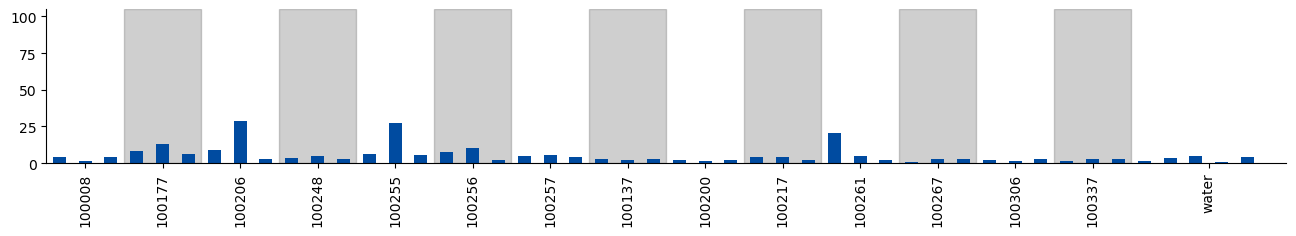

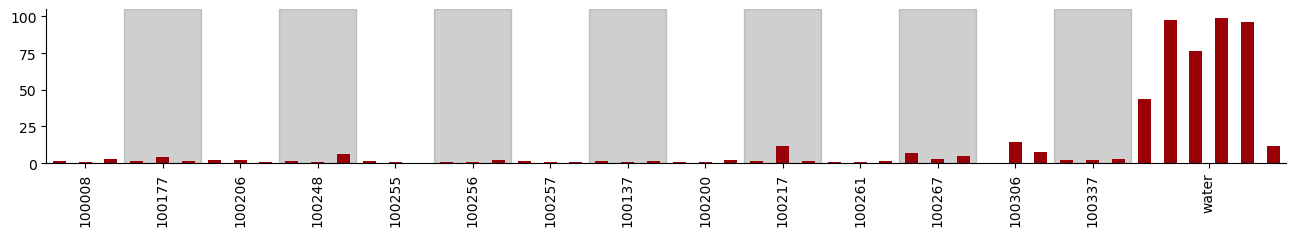

In [22]:
# B: % cleaned
os.makedirs('../figures/sfigures/sfigure2/panel_B/', exist_ok=True)
plot_stats(r,r["cleaned"], color=dark_blue, ylim=(0, 105), savefig="../figures/sfigures/sfigure2/panel_B/rna_cleaned.svg")
plot_stats(r,d["cleaned"], color=dark_red, ylim=(0, 105), savefig="../figures/sfigures/sfigure2/panel_B/dna_cleaned.svg")

### Panel C

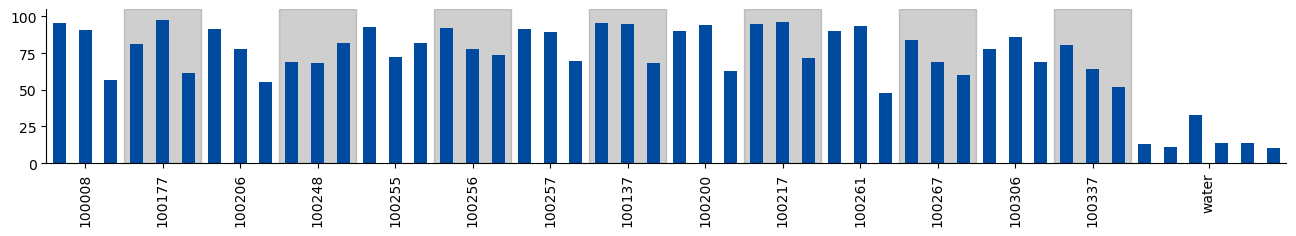

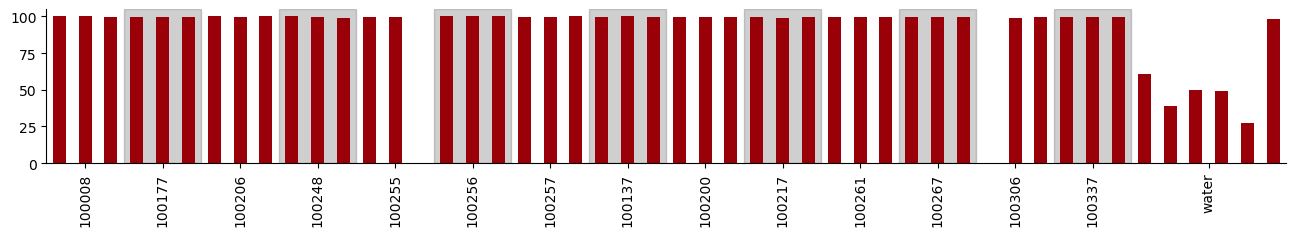

In [23]:
# C: % human
os.makedirs('figures/sfigures/sfigure2/panel_C/', exist_ok=True)
plot_stats(r,r["human"], color=dark_blue, ylim=(0, 105), savefig="../figures/sfigures/sfigure2/panel_C/rna_human.svg")
plot_stats(r,d["human"], color=dark_red, ylim=(0, 105), savefig="../figures/sfigures/sfigure2/panel_C/dna_human.svg")

### Panel D

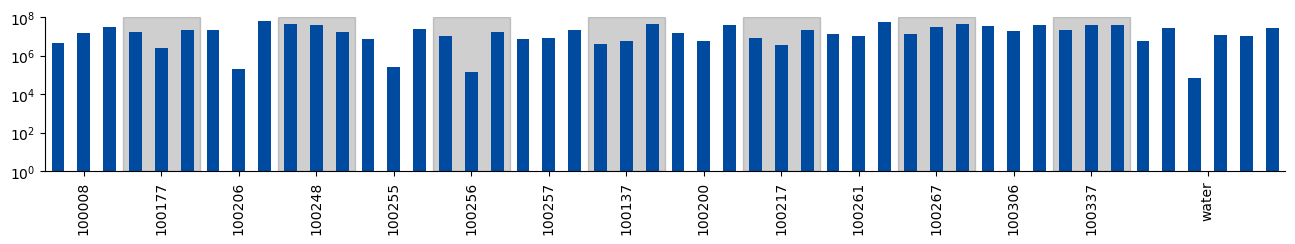

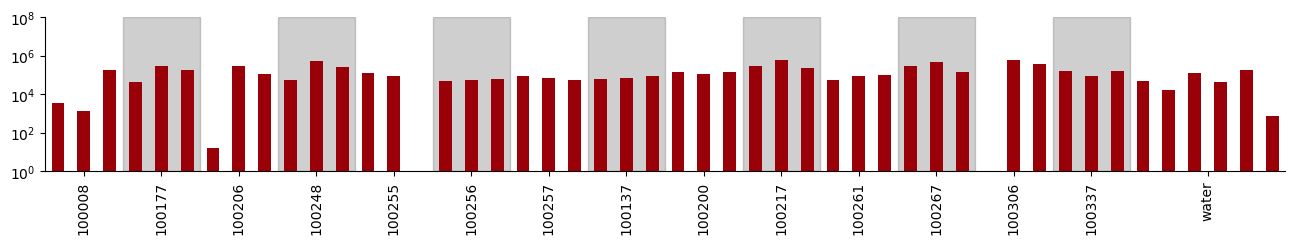

In [24]:
# D: No. nonhuman

os.makedirs('../figures/sfigures/sfigure2/panel_D/', exist_ok=True)
x = nh[["human_genome_fastq.1", "human_genome_fastq.U"]].sum(axis=1).loc[r.index]
plot_stats(r,x, color=dark_blue, yscale="log", ylim=(1, 1e8), savefig="../figures/sfigures/sfigure2/panel_D/rna_nonhuman.svg")

x = nh[["human_genome_fastq.1", "human_genome_fastq.U"]].sum(axis=1).reindex(
    list(meta1.loc[pre_sa.index[:-6], "other_name"]) + list(pre_sa.index[-6:]))
plot_stats(r,x, color=dark_red, yscale="log", ylim=(1, 1e8), savefig="../figures/sfigures/sfigure2/panel_D/dna_nonhuman.svg")

# Figure S3 - HIV coverage, counts and trees

## Panel A - Coverage

In [49]:
# # Coverage/sample
# hiv_coverage = pd.DataFrame(index=np.arange(9034), columns=meta1.index)
# for s in hiv_coverage.columns:
#     print(s)
#     F = "../pileups/{}.mpileup".format(s)
#     coverage = []
#     df = pd.read_table(F, names=["ref", "index", "base", "coverage", "extra", "extra2"]).set_index("index")
#     df.index = df.index - 1
#     hiv_coverage[F.split("/")[-1].split(".")[0]] = df.reindex(hiv_coverage.index)["coverage"].fillna(0)

In [35]:
#hiv_coverage.reset_index().to_csv('tables/hiv_coverage.csv', index=False)

In [39]:
hiv_coverage = pd.read_csv('tables/hiv_coverage.csv', index_col = 0)

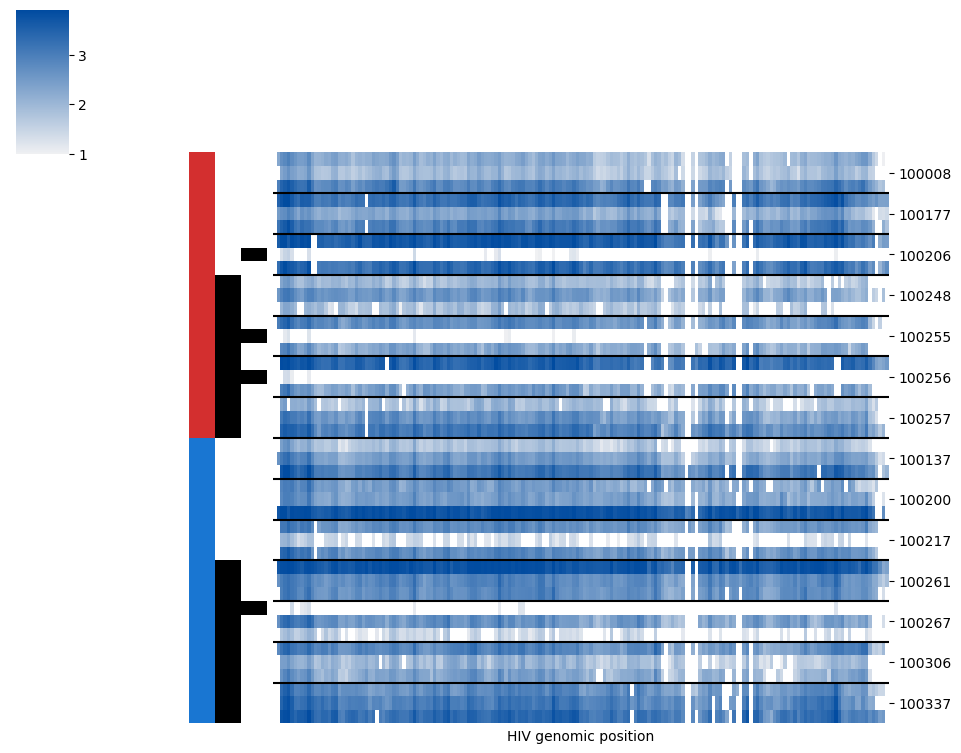

In [38]:
# Order of samples
a = list(design.query("bNAbs == 'Y'").index)
b = list(design.query("bNAbs == 'N'").index)
c = a + b

colors = [21*[red] + 21*[blue],
          9*["white"] + 12*["black"] + 9*["white"] + 12*["black"],
          ["black" if i in [7, 13, 16, 33] else "white" for i in range(42)]]

x = np.log10(hiv_coverage.T.loc[c]+1)
x = x.T
x["row"] = [i // 50 for i in x.index]
x = x.groupby("row").mean().T

mask = hiv_coverage.T.loc[c].T < 8
mask["row"] = [i // 50 for i in mask.index]
mask = mask.groupby("row").mean().T > 0

g = sns.clustermap(x, cmap=sns.light_palette(dark_blue, as_cmap=True),
           row_cluster=False, col_cluster=False, figsize=(42/4, 8),
           row_colors=colors, mask=mask)

g.ax_heatmap.set_yticks([i*3+1.5 for i in range(14)])
g.ax_heatmap.set_yticklabels(breadth_metadata.loc[c]["Patient"].unique())
g.ax_heatmap.set_ylabel('')
g.ax_heatmap.set_xlabel('HIV genomic position')
g.ax_heatmap.set_xticks([])

for i in range(1,14):
    g.ax_heatmap.axhline(i*3, color='k')
os.makedirs('figures/sfigures/sfigure3/panel_A/', exist_ok=True)
g.savefig("figures/sfigures/sfigure3/panel_A/coverage_heatmap.svg")

## Panel B - Counts

In [ ]:
# def bam_counts(bam):
#     counts = 0
#     for aln in HTSeq.BAM_Reader(bam):
#         if aln.aligned:
#             if aln.paired_end:
#                 if aln.mate_aligned:
#                     if aln.pe_which == "first":
#                         counts += 1
#                 else:
#                     counts += 1
                    
#             counts += 1
#     return counts

In [ ]:
# hiv_counts = {}
# for s in meta1.index:
#     try:
#         print(s)
#         f = "../blast_hiv_consensus/{}_HIV.sorted.bam".format(s)
        
#         hiv_counts[s] = bam_counts(f)
#     except Exception as e:
#         print(e)
#         print(s)
#         f = "../blast_hiv_consensus/low_coverage_samples/{}_HIV.sorted.bam".format(s)
        
#         hiv_counts[s] = bam_counts(f)

SAMPLE_100008_1
SAMPLE_100008_2


[W::hts_idx_load3] The index file is older than the data file: ../blast_hiv_consensus/SAMPLE_100008_2_HIV.sorted.bam.bai


SAMPLE_100008_3
SAMPLE_100137_1
SAMPLE_100137_2


[W::hts_idx_load3] The index file is older than the data file: ../blast_hiv_consensus/SAMPLE_100137_1_HIV.sorted.bam.bai


SAMPLE_100137_3
SAMPLE_100177_1


[W::hts_idx_load3] The index file is older than the data file: ../blast_hiv_consensus/SAMPLE_100177_1_HIV.sorted.bam.bai


SAMPLE_100177_2


[W::hts_idx_load3] The index file is older than the data file: ../blast_hiv_consensus/SAMPLE_100177_2_HIV.sorted.bam.bai


SAMPLE_100177_3
SAMPLE_100200_1


[W::hts_idx_load3] The index file is older than the data file: ../blast_hiv_consensus/SAMPLE_100200_1_HIV.sorted.bam.bai


SAMPLE_100200_2
SAMPLE_100200_3
SAMPLE_100206_1


[W::hts_idx_load3] The index file is older than the data file: ../blast_hiv_consensus/SAMPLE_100206_1_HIV.sorted.bam.bai


SAMPLE_100206_2
SAMPLE_100206_3
SAMPLE_100217_1
SAMPLE_100217_2
SAMPLE_100217_3
SAMPLE_100248_1
SAMPLE_100248_2


[W::hts_idx_load3] The index file is older than the data file: ../blast_hiv_consensus/SAMPLE_100248_2_HIV.sorted.bam.bai


SAMPLE_100248_3
SAMPLE_100255_1


[W::hts_idx_load3] The index file is older than the data file: ../blast_hiv_consensus/SAMPLE_100255_1_HIV.sorted.bam.bai


SAMPLE_100255_2
SAMPLE_100255_3


[W::hts_idx_load3] The index file is older than the data file: ../blast_hiv_consensus/SAMPLE_100255_3_HIV.sorted.bam.bai


SAMPLE_100256_1
SAMPLE_100256_2
SAMPLE_100256_3


[W::hts_idx_load3] The index file is older than the data file: ../blast_hiv_consensus/SAMPLE_100256_3_HIV.sorted.bam.bai


SAMPLE_100257_1
SAMPLE_100257_2


[W::hts_idx_load3] The index file is older than the data file: ../blast_hiv_consensus/SAMPLE_100257_1_HIV.sorted.bam.bai


SAMPLE_100257_3
SAMPLE_100261_1
SAMPLE_100261_2


[W::hts_idx_load3] The index file is older than the data file: ../blast_hiv_consensus/SAMPLE_100261_2_HIV.sorted.bam.bai


SAMPLE_100261_3


[W::hts_idx_load3] The index file is older than the data file: ../blast_hiv_consensus/SAMPLE_100261_3_HIV.sorted.bam.bai


SAMPLE_100267_1
SAMPLE_100267_2


[W::hts_idx_load3] The index file is older than the data file: ../blast_hiv_consensus/SAMPLE_100267_1_HIV.sorted.bam.bai


SAMPLE_100267_3
SAMPLE_100306_1


[W::hts_idx_load3] The index file is older than the data file: ../blast_hiv_consensus/SAMPLE_100267_3_HIV.sorted.bam.bai


SAMPLE_100306_2
SAMPLE_100306_3
SAMPLE_100337_1
SAMPLE_100337_2
SAMPLE_100337_3


[W::hts_idx_load3] The index file is older than the data file: ../blast_hiv_consensus/SAMPLE_100337_3_HIV.sorted.bam.bai


In [ ]:
# import pickle
# with open('tables/hiv_counts.txt', 'wb') as fp:
#     pickle.dump(hiv_counts, fp)

In [46]:
import pickle
with open('tables/hiv_counts.txt', 'rb') as fp:
    hiv_counts = pickle.load(fp)

In [47]:
pd.Series(hiv_counts)#.plot.barh(color=dark_blue)
#plt.xscale("log")

SAMPLE_100008_1      24243
SAMPLE_100008_2      15250
SAMPLE_100008_3     145574
SAMPLE_100137_1      11538
SAMPLE_100137_2      53694
SAMPLE_100137_3     254227
SAMPLE_100177_1     334528
SAMPLE_100177_2      37201
SAMPLE_100177_3     158078
SAMPLE_100200_1      47061
SAMPLE_100200_2      47928
SAMPLE_100200_3    1193064
SAMPLE_100206_1    1017890
SAMPLE_100206_2        908
SAMPLE_100206_3     364911
SAMPLE_100217_1      84875
SAMPLE_100217_2       2867
SAMPLE_100217_3     106600
SAMPLE_100248_1      14794
SAMPLE_100248_2      65098
SAMPLE_100248_3      10329
SAMPLE_100255_1      99704
SAMPLE_100255_2        552
SAMPLE_100255_3      36116
SAMPLE_100256_1     611134
SAMPLE_100256_2        394
SAMPLE_100256_3      52649
SAMPLE_100257_1      13810
SAMPLE_100257_2      80263
SAMPLE_100257_3     208587
SAMPLE_100261_1    1467030
SAMPLE_100261_2     115083
SAMPLE_100261_3      98507
SAMPLE_100267_1        696
SAMPLE_100267_2      73142
SAMPLE_100267_3       3878
SAMPLE_100306_1     123154
S

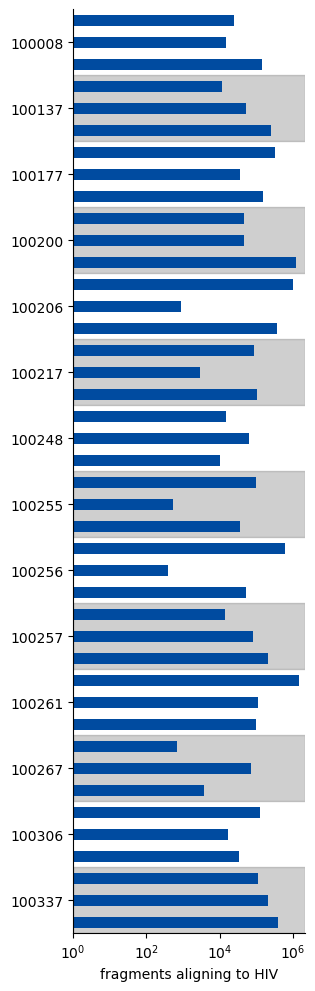

In [48]:
plt.figure(figsize=(3, 12))
pd.Series(hiv_counts).plot.barh(color=dark_blue)
plt.xscale("log")
plt.xlim(1, plt.xlim()[1])
sns.despine()
plt.xlabel("fragments aligning to HIV")

for i in range(14):
    if (i % 2) == 1:
        plt.axhspan(ymin=i*3-0.5, ymax=(i+1)*3-0.5, zorder=0, color=grey, alpha=0.3)

# if the other figure is the reverse order, do this:
plt.gca().invert_yaxis()
plt.yticks(np.arange(14)*3+1, meta1["PID"].unique())

os.makedirs('figures/sfigures/sfigure3/panel_B/', exist_ok=True)
plt.savefig("figures/sfigures/sfigure3/panel_B/HIV_counts.svg")
plt.show()


## Panel C - Tree

## Panel D - SNVs

In [ ]:
# from pathlib import Path

# sample_consenses = pd.DataFrame(index=c, columns=range(1, 9035), dtype=object)
# cols = ['CHROM','POS','ID','REF','ALT','QUAL','FILTER','INFO','FORMAT','SAMPLE']

# for s in glob.glob("../blast_hiv_consensus/*.vcf"):
#     name = Path(s).stem.split('_HIV')[0]
#     if name in sample_consenses.index:
#         # skip any header lines starting with '#'
#         df = pd.read_csv(s, sep="\t", comment="#", header=None, names=cols, usecols=['POS','REF','ALT'])

#         # If ALT has multiple alleles "A,G"
#         df['ALT'] = df['ALT'].astype(str).str.split(',').str[0]
#         snv = df[(df['REF'].str.len()==1) & (df['ALT'].str.len()==1)].copy()

#         snv = snv[snv['POS'].isin(sample_consenses.columns)]

#         # Fill just POS - others NaN 
#         sample_consenses.loc[name, snv['POS'].to_numpy()] = snv['ALT'].to_numpy()
        
# # Remove low coverage samples and the mislabelled one too
# #sample_consenses.drop(labels=["SAMPLE_100206_2", "SAMPLE_100255_2", "SAMPLE_100256_2", "SAMPLE_100267_1",
#                             # "SAMPLE_100200_1"], inplace=True)

In [ ]:
# import pickle
# with open('tables/sample_consenses.csv', 'wb') as fp:
#      pickle.dump(sample_consenses, fp)

In [105]:
import pickle
with open('tables/sample_consenses.csv', 'rb') as fp:
    sample_consenses = pickle.load(fp)


In [ ]:
# def pileup(filename):
#     """ Returns a DataFrame of the pileup information """
#     df = pd.DataFrame(columns=["A", "C", "G", "T"])
#     bam = pysam.AlignmentFile(filename, "rb")
#     for column in bam.pileup():
#         df.loc[column.pos + 1] = 0
#         for read in column.pileups:
#             if not read.is_del and not read.is_refskip:
#                 base = read.alignment.query_sequence[read.query_position]
#                 if base != "N":
#                     df.at[column.pos + 1, base] += 1
#     bam.close()
#     return df

In [ ]:
# pileups = {}
# for f in glob.glob("../blast_hiv_consensus/*bam"):
#     k = f.split("/")[-1].split(".")[0].split('_HIV')[0]
#     pileups[k] = pd.read_csv("../HIV/{}_pileup.txt".format(k), sep="\t", index_col=0)

In [ ]:
# import pickle
# with open('tables/pileups.txt', 'wb') as fp:
#      pickle.dump(pileups, fp)

In [68]:
import pickle
with open('tables/pileups.txt', 'rb') as fp:
    pileups = pickle.load(fp)

In [74]:
# from scipy.stats import entropy
# entropies = {}
# for k in pileups:
#     print(k)
#     x = pileups[k].reindex(sample_consenses.columns)
#     x[x.sum(axis=1) == 0] = np.nan # Make sure zeros are nan so I don't plot these points
#     x.dropna(inplace=True)
#     x = x.div(x.sum(axis=1), axis=0).reindex(sample_consenses.columns)
#     entropies[k] = x.apply(lambda i: entropy(i.value_counts().values, base=2), axis=1)

In [75]:
# import pickle
# with open('tables/entropies.txt', 'wb') as fp:
#       pickle.dump(entropies, fp)

In [76]:
import pickle
with open('tables/entropies.txt', 'rb') as fp:
    entropies = pickle.load(fp)


In [83]:
def different_SNVs(i, j):
    """ Finds locations of different SNVs """
    x = sample_consenses.loc[[i, j], sample_consenses.loc[i] != sample_consenses.loc[j]]
    return x.replace(".", np.nan).dropna(axis=1).columns

def plot_sample_SNVs(s, snvs=[]):
    figsize(15, 2)
    x = pileups[s].reindex(sample_consenses.columns)
    x[x.sum(axis=1) == 0] = np.nan # Make sure zeros are nan so I don't plot these points
    x.dropna(inplace=True)
    x = x.div(x.sum(axis=1), axis=0).reindex(snvs)
    x.plot.bar(stacked=True, color=[blue, red, green, yellow], width=0.8)
    sns.despine()
    plt.xticks([])
    plt.legend(loc=(1, 0))
    plt.title(s)
    plt.show()
    
def plot_HIV_snvs(y, s, SNVs):
    ax = plt.gca()
    colors = []
    for l in SNVs:
        if sample_consenses.loc[s, l] == "G":
            color=green
        elif sample_consenses.loc[s, l] == "T":
            color=yellow
        elif sample_consenses.loc[s, l] == "C":
            color=red
        elif sample_consenses.loc[s, l] == "A":
            color=blue
        else:
            color=grey
        colors.append(color)
    ax.scatter(SNVs, [y]*len(SNVs), marker="|", color=colors)

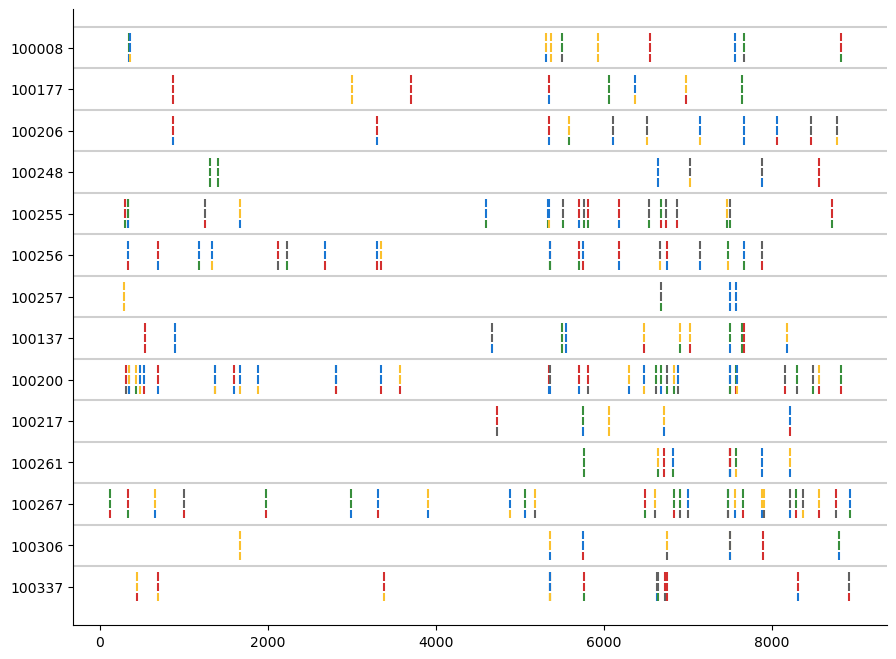

In [107]:
figsize(42/4, 8)
n = 0
ylocs, ylabels = [], []

a = list(design.query("bNAbs == 'Y'").index)
b = list(design.query("bNAbs == 'N'").index)
c = a + b

for p in meta1.loc[c]["PID"].unique()[::-1]:
    g = meta1.loc[sample_consenses.index][meta1.loc[sample_consenses.index, "PID"] == p]
    if len(g) == 2:
        i, j = g.index
        d = different_SNVs(i, j)
        plot_HIV_snvs(n, i, d)
        plot_HIV_snvs(n+1, j, d)
        plt.axhline(y=n+2, color=grey, alpha=0.3)
        ylocs.append((2*n+3)/2-1)
        ylabels.append(p)
        n += 3
    else:
        i, j, k = g.index
        d1 = different_SNVs(i, j)
        d2 = different_SNVs(i, k)
        d3 = different_SNVs(j, k)
        d = d1.union(d2).union(d3)
        plot_HIV_snvs(n, i, d)
        plot_HIV_snvs(n+1, j, d)
        plot_HIV_snvs(n+2, j, d)
        plt.axhline(y=n+3, color=grey, alpha=0.3)
        ylocs.append((2*n+4)/2-1)
        ylabels.append(p)
        n += 4

#plt.xlim(0, 9035)
plt.yticks(ylocs, ylabels)
sns.despine()
os.makedirs('figures/sfigures/sfigure3/panel_D', exist_ok=True)
plt.savefig("figures/sfigures/sfigure3/panel_D/HIV_SNV_positions.svg")

## Panel E

In [108]:
a = list(design.query("bNAbs == 'Y'").index)
b = list(design.query("bNAbs == 'N'").index)
c = a + b

In [109]:
from collections.abc import Sized
def mutation_rate(start, end, mutations, unit="months"):
    # ensure pandas Timestamps
    start = pd.to_datetime(start)
    end   = pd.to_datetime(end)

    # duration in days
    delta_days = (end - start) / np.timedelta64(1, "D")

    # convert to requested unit
    if unit == "months":
        duration = delta_days / 30.4375        # average days/month
    elif unit == "years":
        duration = delta_days / 365.25
    elif unit == "weeks":
        duration = delta_days / 7.0
    elif unit == "days":
        duration = delta_days
    else:
        raise ValueError("unit must be one of: 'months', 'years', 'weeks', 'days'")

    # count mutations 
    try:
        # if it's boolean-like
        if getattr(mutations, "dtype", None) == bool or (
            hasattr(mutations, "dtype") and str(mutations.dtype) == "bool"
        ):
            n = int(np.count_nonzero(mutations))
        else:
            n = len(mutations) if isinstance(mutations, Sized) else int(mutations)
    except Exception:
        n = int(np.count_nonzero(mutations))

    return duration, n

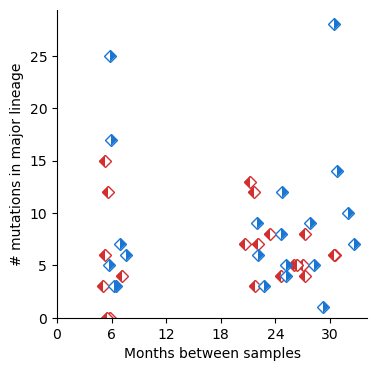

In [116]:
TM = []
figsize(4, 4)
for p in meta1.loc[c]["PID"].unique():
    g = meta1.loc[sample_consenses.index][meta1.loc[sample_consenses.index, "PID"] == p]
    if design.loc[g.index[0], "bNAbs"] == "Y":
        color=red
        fillstyle="left"
    else:
        color=blue
        fillstyle="right"
    if len(g) == 2:
        i, j = g.index
        d = different_SNVs(i, j)
        t1, t2 = meta1.loc[i]["vdate"], meta1.loc[j]["vdate"]
        plt.plot(*mutation_rate(t1, t2, d), color=color, marker="D", 
                 markerfacecoloralt="white", linewidth=0, markeredgewidth=0, fillstyle=fillstyle)
        plt.plot(*mutation_rate(t1, t2, d), color=color, marker="D", 
                 markerfacecoloralt="white", linewidth=0, markeredgewidth=1, fillstyle="none")
        TM.append(mutation_rate(t1, t2, d))
    else:
        i, j, k = g.index
        d1 = different_SNVs(i, j)
        d2 = different_SNVs(i, k)
        d3 = different_SNVs(j, k)
        #d = d1 | d2 | d3
        d = pd.Index(d1).union(d2).union(d3)
        t1, t2, t3 = meta1.loc[i]["vdate"], meta1.loc[j]["vdate"], meta1.loc[k]["vdate"]
        # t1, t2
        plt.plot(*mutation_rate(t1, t2, d1), color=color, marker="D", 
                 markerfacecoloralt="white", linewidth=0, markeredgewidth=0, fillstyle=fillstyle)
        plt.plot(*mutation_rate(t1, t2, d1), color=color, marker="D", 
                 markerfacecoloralt="white", linewidth=0, markeredgewidth=1, fillstyle="none")
        TM.append(mutation_rate(t1, t2, d1))
        # t1, t3
        plt.plot(*mutation_rate(t1, t3, d2), color=color, marker="D", 
                 markerfacecoloralt="white", linewidth=0, markeredgewidth=0, fillstyle=fillstyle)
        plt.plot(*mutation_rate(t1, t3, d2), color=color, marker="D", 
                 markerfacecoloralt="white", linewidth=0, markeredgewidth=1, fillstyle="none")
        TM.append(mutation_rate(t1, t3, d2))
        # t2, t3
        plt.plot(*mutation_rate(t2, t3, d3), color=color, marker="D", 
                 markerfacecoloralt="white", linewidth=0, markeredgewidth=0, fillstyle=fillstyle)
        plt.plot(*mutation_rate(t2, t3, d3), color=color, marker="D", 
                 markerfacecoloralt="white", linewidth=0, markeredgewidth=1, fillstyle="none")
        TM.append(mutation_rate(t2, t3, d3))
    
plt.xlim(0, plt.xlim()[1])
plt.ylim(0, plt.ylim()[1])
plt.xticks([0, 6, 12, 18, 24, 30])
plt.xlabel("Months between samples")
plt.ylabel("# mutations in major lineage")
sns.despine()
os.makedirs('figures/sfigures/sfigure3/panel_E', exist_ok=True)
plt.savefig("figures/sfigures/sfigure3/panel_E/HIV_mutation_rate.svg")
plt.show()

## Transcriptome

In [117]:
genes = pd.read_table("tables/gene_counts.txt", index_col=0).T

genes_duprm = genes.copy().loc[[s for s in genes.index if "duprm" in s]]
genes_duprm["sample"] = [s.split(".")[0] for s in genes_duprm.index]
genes_duprm = genes_duprm.groupby("sample").sum().T

genes = genes.copy().loc[[s for s in genes.index if "duprm" not in s]]
genes["sample"] = [s.split(".")[0] for s in genes.index]
genes = genes.groupby("sample").sum().T

In [118]:
just_genes = genes.iloc[:-5]
just_genes = genes.loc[[g for g in genes.index if "ENSG" in g]]
cpm = (1e6*just_genes.div(just_genes.sum()))
logCPM = np.log10(cpm+1)

X = logCPM.loc[:, meta1.index.difference(["SAMPLE_100200_1"])].T

In [ ]:
#just_genes.loc[:, X.index].to_csv("just_gene_counts.txt", sep="\t") # Just good samples here

# Figure S4 - Correlations with clinical outcomes

In [120]:
# Load gene names and HIV associated genes
ensembl = pd.read_table("tables/ensembl.tsv", index_col=0)
ensembl_clean = ensembl[ensembl["Gene name"].apply(lambda s: len(s.split("-"))) == 1]

hiv_genes = pd.read_excel("tables/MalaCards-HIV.xlsx", index_col=0)
hiv_genes["gene"] = hiv_genes["Symbol"].apply(lambda s: s.split()[0])
hiv_genes.index = hiv_genes["gene"]
hiv_ensembl = [g for g in ensembl.index if ensembl.loc[g, "Gene name"] in hiv_genes["gene"].values]

In [121]:
clin_gene_corr = pd.read_table("tables/clinicalmeasurements_gene_correlations.txt", index_col=0)

## Panel A

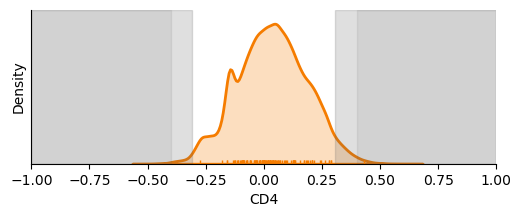

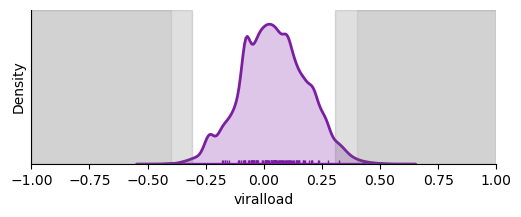

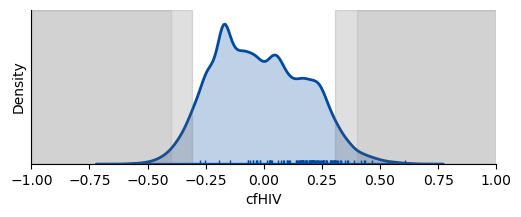

In [122]:
os.makedirs('figures/sfigures/sfigure4/panel_A', exist_ok=True)

figsize(6, 2)
sns.kdeplot(clin_gene_corr["CD4"].dropna(), shade=True, color=orange, linewidth=2, legend=False)
sns.rugplot(clin_gene_corr["CD4"].reindex(hiv_ensembl).dropna(), color=orange)
plt.axvspan(xmin=-1, xmax=-0.307, color=grey, alpha=0.2)
plt.axvspan(xmin=-1, xmax=-0.4, color=grey, alpha=0.1)
plt.axvspan(xmin=0.307, xmax=1, color=grey, alpha=0.2)
plt.axvspan(xmin=0.4, xmax=1, color=grey, alpha=0.1)
plt.yticks([])
plt.xlim(-1, 1)
sns.despine()
plt.savefig("figures/sfigures/sfigure4/panel_A/correlation_CD4.svg")
plt.show()

sns.kdeplot(clin_gene_corr["viralload"].dropna(), shade=True, color=purple, linewidth=2, legend=False)
sns.rugplot(clin_gene_corr["viralload"].reindex(hiv_ensembl).dropna(), color=purple)
plt.axvspan(xmin=-1, xmax=-0.307, color=grey, alpha=0.2)
plt.axvspan(xmin=-1, xmax=-0.4, color=grey, alpha=0.1)
plt.axvspan(xmin=0.307, xmax=1, color=grey, alpha=0.2)
plt.axvspan(xmin=0.4, xmax=1, color=grey, alpha=0.1)
plt.yticks([])
plt.xlim(-1, 1)
sns.despine()
plt.savefig("figures/sfigures/sfigure4/panel_A/correlation_viralload.svg")
plt.show()

sns.kdeplot(clin_gene_corr["cfHIV"].dropna(), shade=True, color=dark_blue, linewidth=2, legend=False)
sns.rugplot(clin_gene_corr["cfHIV"].reindex(hiv_ensembl).dropna(), color=dark_blue)
plt.axvspan(xmin=-1, xmax=-0.307, color=grey, alpha=0.2)
plt.axvspan(xmin=-1, xmax=-0.4, color=grey, alpha=0.1)
plt.axvspan(xmin=0.307, xmax=1, color=grey, alpha=0.2)
plt.axvspan(xmin=0.4, xmax=1, color=grey, alpha=0.1)
plt.yticks([])
plt.xlim(-1, 1)
sns.despine()
plt.savefig("figures/sfigures/sfigure4/panel_A/correlation_cfHIV.svg")
plt.show()

In [123]:
clin_num_correlated = pd.DataFrame(index=["cfHIV", "viralload", "CD4"], columns=["u5", "d5", "u1", "d1"])
for c in clin_num_correlated.index:
    u5 = (clin_gene_corr[c][clin_gene_corr[c+"_p"] <= 0.05].dropna() > 0).sum()
    d5 = (clin_gene_corr[c][clin_gene_corr[c+"_p"] <= 0.05].dropna() < 0).sum()
    u1 = (clin_gene_corr[c][clin_gene_corr[c+"_p"] <= 0.01].dropna() > 0).sum()
    d1 = (clin_gene_corr[c][clin_gene_corr[c+"_p"] <= 0.01].dropna() < 0).sum()
    clin_num_correlated.loc[c] = u5, d5, u1, d1

In [124]:
clin_num_correlated_HIV = pd.DataFrame(index=["cfHIV", "viralload", "CD4"], columns=["u5", "d5", "u1", "d1"])
for c in clin_num_correlated_HIV.index:
    u5 = (clin_gene_corr[c][clin_gene_corr[c+"_p"] <= 0.05] > 0).reindex(hiv_ensembl).dropna().sum()
    d5 = (clin_gene_corr[c][clin_gene_corr[c+"_p"] <= 0.05] < 0).reindex(hiv_ensembl).dropna().sum()
    u1 = (clin_gene_corr[c][clin_gene_corr[c+"_p"] <= 0.01] > 0).reindex(hiv_ensembl).dropna().sum()
    d1 = (clin_gene_corr[c][clin_gene_corr[c+"_p"] <= 0.01] < 0).reindex(hiv_ensembl).dropna().sum()
    clin_num_correlated_HIV.loc[c] = u5, d5, u1, d1

## Panel B

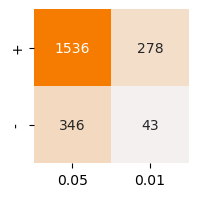

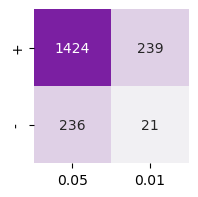

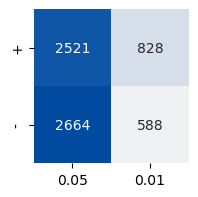

In [126]:
os.makedirs("figures/sfigures/sfigure4/panel_B/", exist_ok=True)

c_color_dict = {"CD4": orange, "viralload":purple, "cfHIV":dark_blue}
for c in ["CD4", "viralload", "cfHIV"]:
    df = pd.DataFrame(index=["+", "-"], columns=["0.05", "0.01"])
    df.loc["+", "0.05"] = clin_num_correlated.loc[c, "u5"]
    df.loc["-", "0.05"] = clin_num_correlated.loc[c, "d5"]
    df.loc["+", "0.01"] = clin_num_correlated.loc[c, "u1"]
    df.loc["-", "0.01"] = clin_num_correlated.loc[c, "d1"]
    df = df.astype(int)
    figsize(2, 2)
    sns.heatmap(df, annot=True, fmt='d', cbar=False, cmap=sns.light_palette(c_color_dict[c], as_cmap=True))
    plt.savefig("figures/sfigures/sfigure4/panel_B/correlation_{}_numbers.svg".format(c))
    plt.show()

## Panel C

In [127]:
meta1 = pd.read_csv('tables/metadata.csv', index_col = 0)

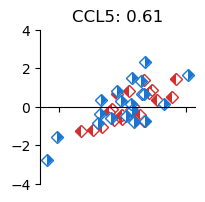

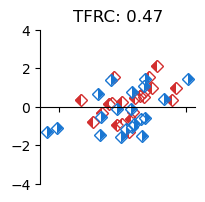

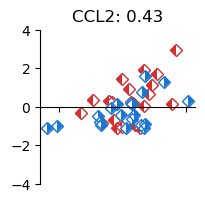

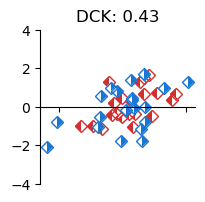

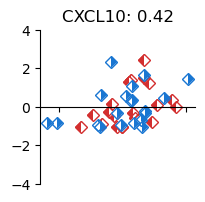

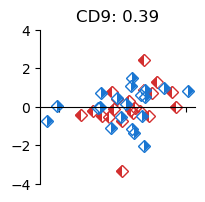

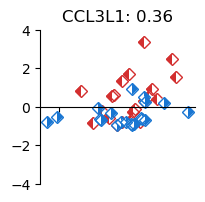

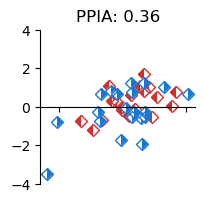

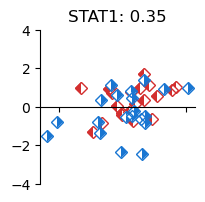

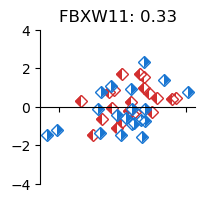

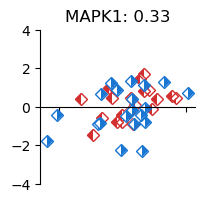

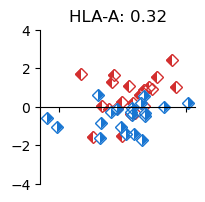

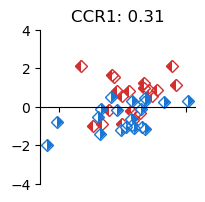

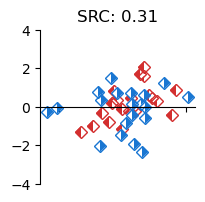

In [129]:
# Scatter plots of most correlated (HIV) genes
os.makedirs("figures/sfigures/sfigure4/panel_C/", exist_ok=True)
top_correlated_cfHIV = clin_gene_corr.query("cfHIV_p <= 0.05").reindex(hiv_ensembl).dropna()

figsize(2, 2)
for g in top_correlated_cfHIV.sort_values(by="cfHIV", ascending=False).index:
    x = meta1.loc[X.index, "cfHIV"]
    y = logCPM.loc[g, X.index]
    y -= y.mean()
    y /= y.std() # z-score of gene expression
    # Different colours and styles for the two groups
    i = design.loc[x.index].query("bNAbs == 'Y'").index
    plt.plot(x.loc[i], y.loc[i], color=red, marker="D", 
             markerfacecoloralt="white", linewidth=0, markeredgewidth=0, fillstyle="left")
    plt.plot(x.loc[i], y.loc[i], color=red, marker="D", 
             markerfacecoloralt="white", linewidth=0, markeredgewidth=1, fillstyle="none")
    i = design.loc[x.index].query("bNAbs == 'N'").index
    plt.plot(x.loc[i], y.loc[i], color=blue, marker="D", 
             markerfacecoloralt="white", linewidth=0, markeredgewidth=0, fillstyle="right")
    plt.plot(x.loc[i], y.loc[i], color=blue, marker="D", 
             markerfacecoloralt="white", linewidth=0, markeredgewidth=1, fillstyle="none")
    plt.ylim(-4, 4)
    plt.xscale("log")
    plt.title("{}: {:.2f}".format(ensembl.loc[g, "Gene name"], clin_gene_corr.loc[g, "cfHIV"]))
    ax = plt.gca()
    ax.spines['bottom'].set_position('center')
    plt.xticks([0.1, 100], ["", ""])
    sns.despine()
    
    plt.savefig("figures/sfigures/sfigure4/panel_C/{}.svg".format(ensembl.loc[g, "Gene name"]))
    plt.show()

# Figure S5

## Panel A - Differential Expression

In [130]:
# Load gene names and HIV associated genes
ensembl = pd.read_table("tables/ensembl.tsv", index_col=0)
ensembl_clean = ensembl[ensembl["Gene name"].apply(lambda s: len(s.split("-"))) == 1]

hiv_genes = pd.read_excel("tables/MalaCards-HIV.xlsx", index_col=0)
hiv_genes["gene"] = hiv_genes["Symbol"].apply(lambda s: s.split()[0])
hiv_genes.index = hiv_genes["gene"]
hiv_ensembl = [g for g in ensembl.index if ensembl.loc[g, "Gene name"] in hiv_genes["gene"].values]

In [131]:
# Build HIV Ensembl ID set from MalaCards sheet via gene symbols
hiv_symbols = (
    hiv_genes["Symbol"]
    .astype(str)
    .str.split().str[0]       # take first token like you did
    .str.upper()
    .unique()
)

# Normalize ensembl gene symbols to match casing and tokenization
ensembl["SYMBOL_UP"] = (
    ensembl["Gene name"].astype(str).str.split().str[0].str.upper())

hiv_ensembl_ids = set(
    ensembl.index[ensembl["SYMBOL_UP"].isin(hiv_symbols)])

In [132]:
# DE table
de_bNAbs = pd.read_table("tables/bNAbs.de.new.txt", index_col=0)

# robust -log10(FDR)
de_bNAbs["-logP"] = -np.log10(de_bNAbs["FDR"].clip(lower=np.finfo(float).tiny))


In [133]:
# Add "Gene name"
de_bNAbs = de_bNAbs.join(ensembl[["Gene name"]], how="left").copy()

# Add HIV? flag by checking whether DE Ensembl IDs are in the HIV set
de_bNAbs["HIV?"] = de_bNAbs.index.isin(hiv_ensembl_ids)
#de_bNAbs.to_csv("differential_expression_bNAbs.txt", sep="\t")

In [134]:
#  quick diagnostics
missing = de_bNAbs.index[de_bNAbs["Gene name"].isna()]
if len(missing):
    print(f"{len(missing)} Ensembl IDs in DE not found in ensembl.tsv, e.g.: {list(missing[:10])}")

14 Ensembl IDs in DE not found in ensembl.tsv, e.g.: ['ENSG00000150076', 'ENSG00000272053', 'ENSG00000116957', 'ENSG00000276736', 'ENSG00000208034', 'ENSG00000133808', 'ENSG00000280954', 'ENSG00000281255', 'ENSG00000188206', 'ENSG00000155640']


In [135]:

unmatched_symbols = sorted(set(hiv_symbols) - set(ensembl["SYMBOL_UP"]))
if unmatched_symbols:
    print(f"{len(unmatched_symbols)} HIV symbols not found in ensembl.tsv, e.g.: {unmatched_symbols[:10]}")




2 HIV symbols not found in ensembl.tsv, e.g.: ['ERVK-6', 'LOC102724297']


In [136]:
print("bNABs = Y", len(de_bNAbs.query("logFC > 1").query("FDR < 0.05")))
print("bNABs = N", len(de_bNAbs.query("logFC < -1").query("FDR < 0.05")))

bNABs = Y 256
bNABs = N 281


In [138]:
def plot_GO_bars(df, n=20, color='k', title="", savefig=None, xlim=None,
                 genes="# Matched Genes", total_genes="# Genes"):
    figsize(4, 8)
    x = df["Score"].head(n=n)[::-1]
    x.plot.barh(color=color, width=0.8)
    # Labels
    for i,s in enumerate(x.index):
        plt.text(x.loc[s]+1, i, 
                 "{}/{}".format(df.loc[s, genes], df.loc[s, total_genes]), va="center")
    if xlim is not None:
        plt.xlim(*xlim)
    plt.xlabel("Score")
    plt.ylabel("")
    plt.title(title)
    sns.despine()
    if savefig is not None:
        plt.savefig(savefig)
    plt.show()

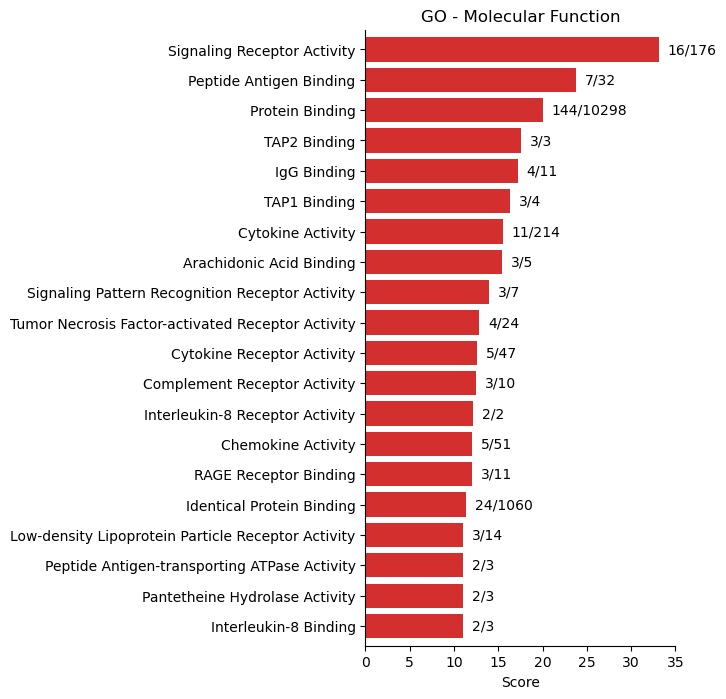

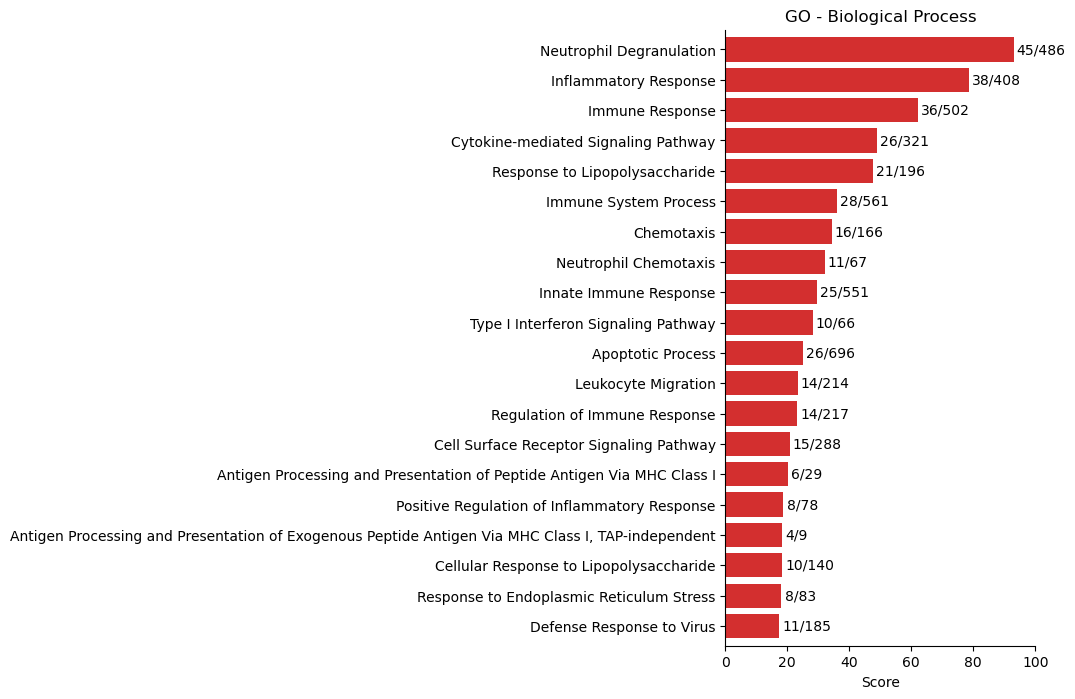

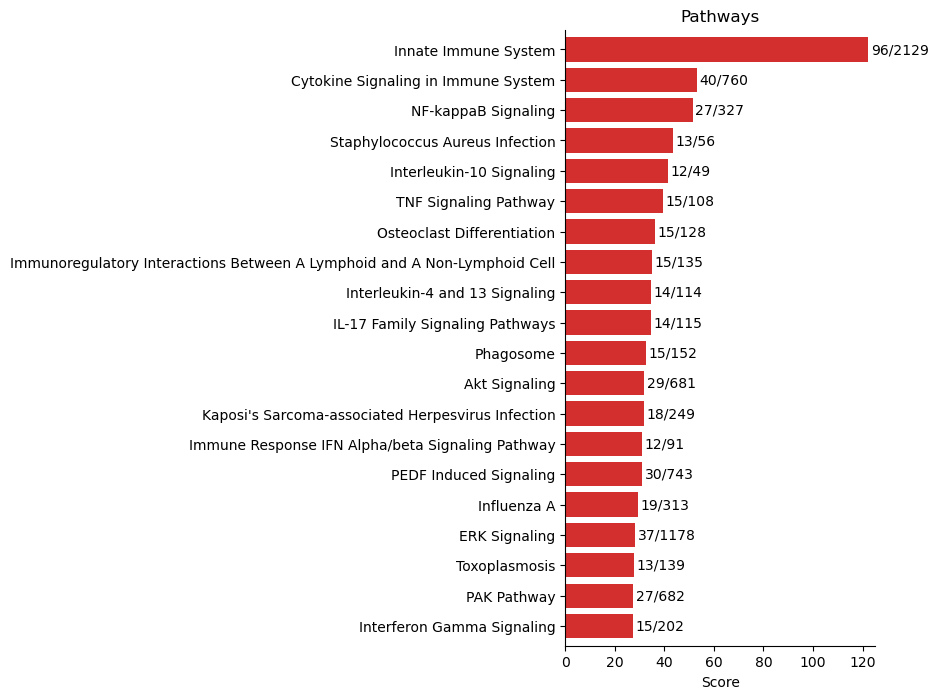

In [140]:
os.makedirs("figures/sfigures/sfigure5/panel_A/", exist_ok=True)
up_go_mf = pd.read_excel("tables/bNAbs-GeneAnalytics_Results_ayeletv-stanford-edu-20181127-105723786.xlsx", 
              sheet_name="GO - Molecular Function", skiprows=18, index_col=1)
plot_GO_bars(up_go_mf, color=red, title="GO - Molecular Function", savefig="figures/sfigures/sfigure5/panel_A/GA_GOMF_bNAbs.svg", xlim=(0, 35))

up_go_bp = pd.read_excel("tables/bNAbs-GeneAnalytics_Results_ayeletv-stanford-edu-20181127-105723786.xlsx", 
              sheet_name="GO - Biological Process", skiprows=18, index_col=1)
plot_GO_bars(up_go_bp, color=red, title="GO - Biological Process", savefig="figures/sfigures/sfigure5/panel_A/GA_GOBP_bNAbs.svg", xlim=(0, 100))

up_pathways = pd.read_excel("tables/bNAbs-GeneAnalytics_Results_ayeletv-stanford-edu-20181127-105723786.xlsx", 
              sheet_name="Pathways", skiprows=18, index_col=1)
plot_GO_bars(up_pathways, color=red, title="Pathways", 
             genes="# SuperPath Matched Genes", total_genes="# SuperPath Total Genes", 
             savefig="figures/sfigures/sfigure5/panel_A/GA_pathways_bNAbs.svg", xlim=(0, 125))

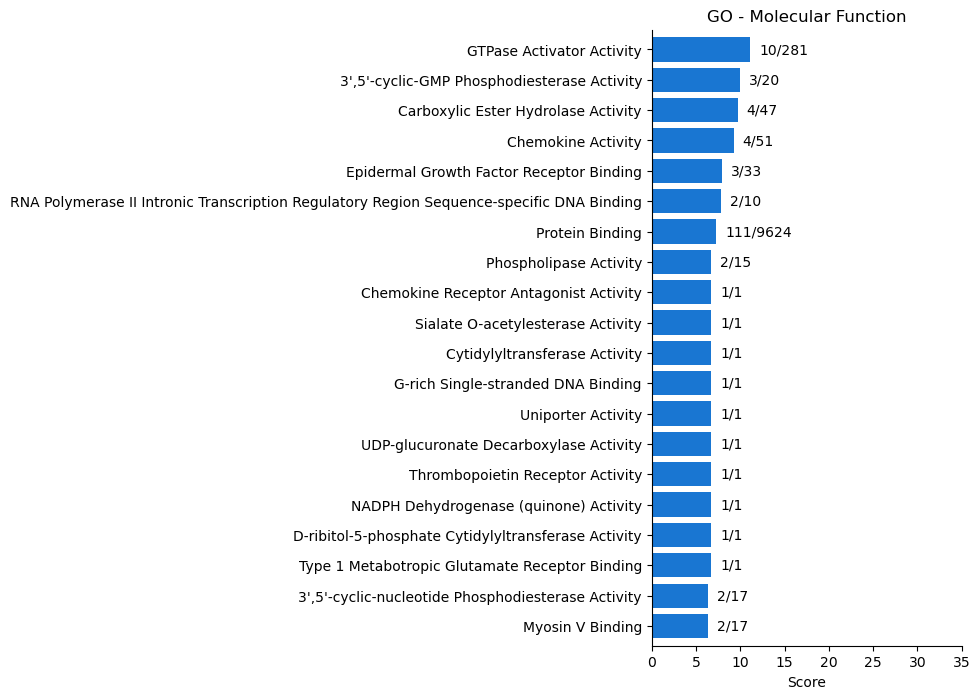

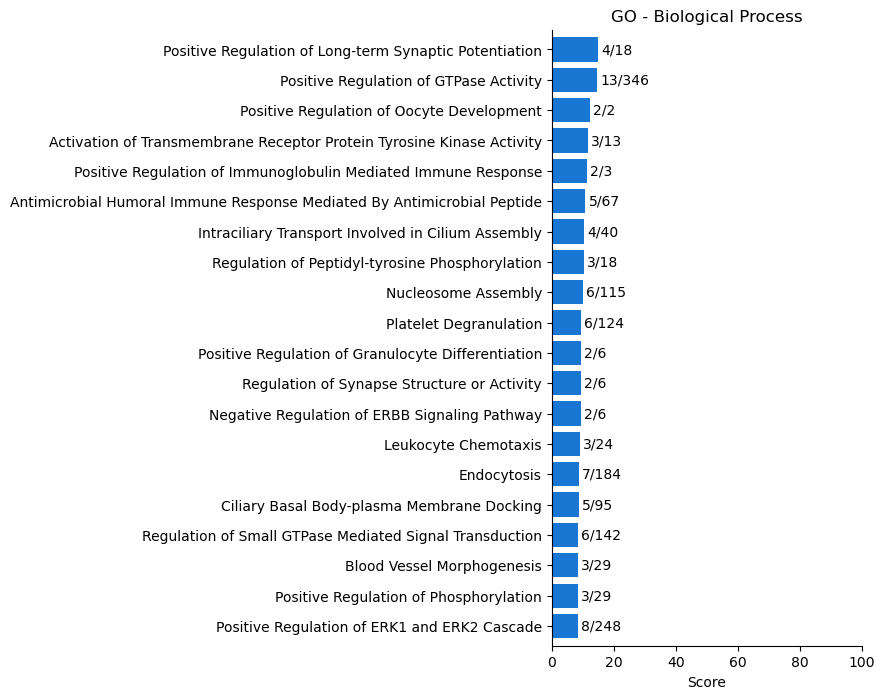

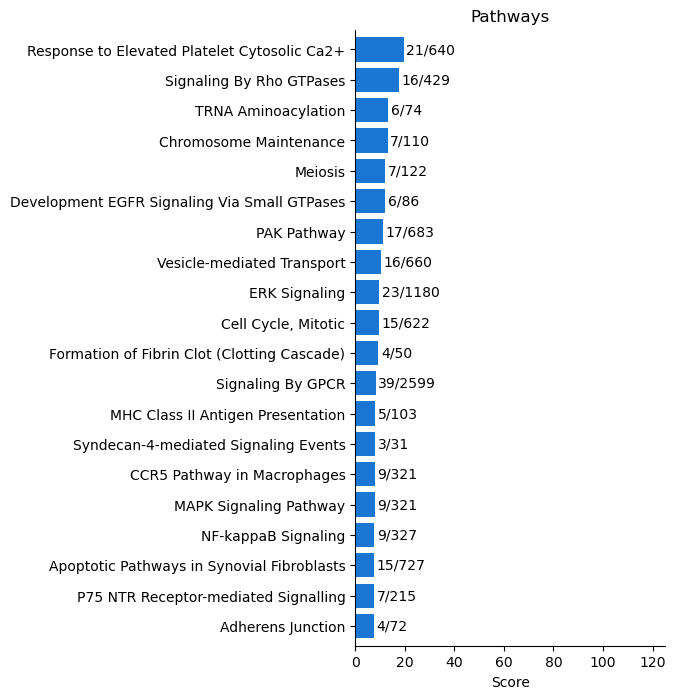

In [143]:
os.makedirs("figures/sfigures/sfigure5/panel_B/", exist_ok=True)
down_go_mf = pd.read_excel("tables/not-bNAbs-GeneAnalytics_Results_ayeletv-stanford-edu-20190326-050855667.xlsx", 
              sheet_name="GO - Molecular Function", skiprows=18, index_col=1)
plot_GO_bars(down_go_mf, color=blue, title="GO - Molecular Function", savefig="figures/sfigures/sfigure5/panel_B/GA_GOMF_notbNAbs.svg", 
             xlim=(0, 35))

down_go_bp = pd.read_excel("tables/not-bNAbs-GeneAnalytics_Results_ayeletv-stanford-edu-20190326-050855667.xlsx", 
              sheet_name="GO - Biological Process", skiprows=18, index_col=1)
plot_GO_bars(down_go_bp, color=blue, title="GO - Biological Process", savefig="figures/sfigures/sfigure5/panel_B/GA_GOBP_notbNAbs.svg",
            xlim=(0, 100))

down_pathways = pd.read_excel("tables/not-bNAbs-GeneAnalytics_Results_ayeletv-stanford-edu-20190326-050855667.xlsx", 
              sheet_name="Pathways", skiprows=18, index_col=1)
plot_GO_bars(down_pathways, color=blue, title="Pathways", 
             genes="# SuperPath Matched Genes", total_genes="# SuperPath Total Genes", 
             savefig="figures/sfigures/sfigure5/panel_B/GA_pathways_notbNAbs.svg", xlim=(0, 125))

### Correlation with production of bNAbs

## Panel C

In [144]:
breadth_corr = pd.read_csv("tables/breadth_gene_correlation.txt", sep="\t", index_col=0)

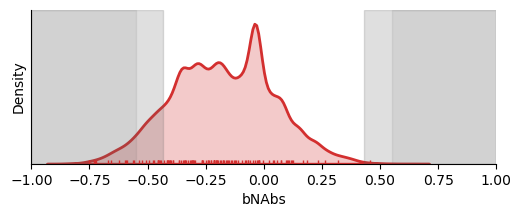

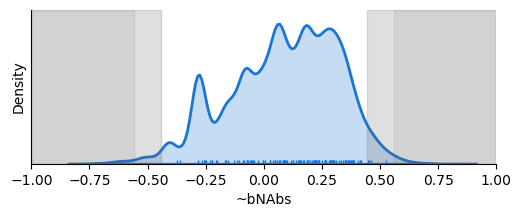

In [145]:
os.makedirs("figures/sfigures/sfigure5/panel_C/", exist_ok=True)
figsize(6, 2)
sns.kdeplot(breadth_corr["bNAbs"].dropna(), shade=True, color=red, linewidth=2, legend=False)
sns.rugplot(breadth_corr["bNAbs"].reindex(hiv_ensembl).dropna(), color=red)
plt.axvspan(xmin=-1, xmax=-0.433, color=grey, alpha=0.2)
plt.axvspan(xmin=-1, xmax=-0.55, color=grey, alpha=0.1)
plt.axvspan(xmin=0.433, xmax=1, color=grey, alpha=0.2)
plt.axvspan(xmin=0.55, xmax=1, color=grey, alpha=0.1)
plt.yticks([])
sns.despine()
plt.xlim(-1, 1)
plt.savefig("figures/sfigures/sfigure5/panel_C/correlation_breadth_bNAbs.svg")
plt.show()

sns.kdeplot(breadth_corr["~bNAbs"].dropna(), shade=True, color=blue, linewidth=2, legend=False)
sns.rugplot(breadth_corr["~bNAbs"].reindex(hiv_ensembl).dropna(), color=blue)
plt.axvspan(xmin=-1, xmax=-0.444, color=grey, alpha=0.2)
plt.axvspan(xmin=-1, xmax=-0.56, color=grey, alpha=0.1)
plt.axvspan(xmin=0.444, xmax=1, color=grey, alpha=0.2)
plt.axvspan(xmin=0.56, xmax=1, color=grey, alpha=0.1)
plt.yticks([])
sns.despine()
plt.xlim(-1, 1)
plt.savefig("figures/sfigures/sfigure5/panel_C/correlation_breadth_notbNAbs.svg")
plt.show()

## Panel D

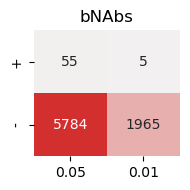

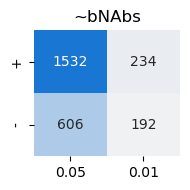

In [146]:
os.makedirs("figures/sfigures/sfigure5/panel_D/", exist_ok=True)
c_color_dict = {"bNAbs": red, "~bNAbs": blue}

for c in ["bNAbs", "~bNAbs"]:
    bc = breadth_corr  # alias for readability
    assert c in bc.columns and f"{c}_p" in bc.columns, f"Missing columns for {c}"

    df = pd.DataFrame(index=["+", "-"], columns=["0.05", "0.01"], dtype=int)

    df.loc["+", "0.05"] = ((bc[c] > 0) & (bc[f"{c}_p"] <= 0.05)).sum()
    df.loc["-", "0.05"] = ((bc[c] < 0) & (bc[f"{c}_p"] <= 0.05)).sum()
    df.loc["+", "0.01"] = ((bc[c] > 0) & (bc[f"{c}_p"] <= 0.01)).sum()
    df.loc["-", "0.01"] = ((bc[c] < 0) & (bc[f"{c}_p"] <= 0.01)).sum()

    figsize(2, 2)
    sns.heatmap(
    df,                 
    annot=True,
    fmt='.0f',          # show as integers
    cbar=False,
    cmap=sns.light_palette(c_color_dict[c], as_cmap=True),
    )

    plt.title(c)
    plt.tight_layout()
    plt.savefig(f'figures/sfigures/sfigure5/panel_D/{c}.svg')
    plt.show()


# Figure S6 - Infectome

In [147]:
ncbi = NCBITaxa()
def taxid_to_kingdom_color(taxid):
    try:
        l = ncbi.get_lineage(taxid)
        if 2 in l:
            return light_red
        elif 10239 in l:
            return light_green
        else:
            return light_purple
    except:
        print(taxid)
        return light_red

In [152]:
ia = pd.read_table("tables/blast.accession", index_col=0, names=["name", "length", "taxid"]) 

In [150]:
# bad RNA and bad DNA
bad_rna = pd.read_csv("tables/bad_rna.csv")
bad_dna = pd.read_csv("tables/bad_dna.csv")

In [151]:
dna_samples = pd.read_csv("tables/dna_samples.csv.bz2", index_col=0)
rna_samples = pd.read_csv("tables/rna_samples.csv.bz2", index_col=0)

In [153]:
# RNA
x = rna_samples.loc[rna_samples.index.difference(bad_rna)]

# ribosomal part
print(100*x.reindex(ia[ia["name"].apply(lambda s: "16S" in s)].index).sum().sum()/x.sum().sum())

38.52322919181843


In [154]:
r = x.copy()
r["taxid"] = ia.loc[r.index, "taxid"]
r = r.groupby(by="taxid").sum()

In [155]:
counts = 100*r.sum(axis=1)/x.sum().sum()
counts.sort_values(ascending=False, inplace=True)
counts =counts[~ (counts.index == '1358;1359')].copy()
taxids = counts.index[:243] # 70% of reads

In [156]:
[(t, counts.loc[t], ncbi.get_taxid_translator([int(t)])[int(t)]) for t in counts.index[:10]]

[('77133', 18.027401239892107, 'uncultured bacterium'),
 ('115547', 10.096212526885187, 'uncultured archaeon'),
 ('54290', 7.816424539056396, 'GB virus C'),
 ('1542133', 3.907281638434384, 'Dickeya phage phiDP23.1'),
 ('55601', 2.912220878597744, 'Vibrio anguillarum'),
 ('36452', 1.8938342118762796, 'Stealth virus 1'),
 ('2306583', 1.4843895730286443, 'Halomonas sp. JS92-SW72'),
 ('1758225', 1.409930248594381, 'Human pegivirus'),
 ('11676', 1.1671239664358115, 'Human immunodeficiency virus 1'),
 ('1491', 1.1356798673298767, 'Clostridium botulinum')]

In [157]:
def pruned_contaminant_tree(taxids, counts,
                  plotted_levels=["no rank", "superkingdom", "phylum", "class", "order", "family", "genus", "species"]):
    """ Creates a pruned tree of the contigs and their tax info """
    tree = ncbi.get_topology(set(taxids), intermediate_nodes=True)
    
    for taxid in taxids:
        try:
            taxid_ = ncbi.get_lineage(taxid)[-1] # Fix name translations
            t = tree & taxid_
            t.add_feature("num", counts.loc[taxid])
        except:
            print(taxid, "ignored")
            t = tree & taxid_
            print(t)
            t.add_feature("num", counts.loc[taxid])
    for t in tree.traverse():
        t.num = sum([node.num if "num" in node.features else 0 for node in t.iter_leaves()])
    # Remove other levels
    for t in tree.iter_descendants(strategy="postorder"):
        if t.rank not in plotted_levels and t.up is not None:
            t.delete(prevent_nondicotomic=False)
        for t in tree.iter_descendants():
            if t.rank == 'no rank' and t.up is not None:
                t.delete(prevent_nondicotomic=False)
    return tree

In [158]:
fsize=16
def layout(node, label=False, color='k'):
    style = NodeStyle()
    style["size"] = np.sqrt(node.num)
    style["shape"] = "sphere"
    style["fgcolor"] = color
    style["vt_line_width"] = 2
    style["hz_line_width"] = 2
    node.set_style(style)
    if label:
        face = faces.AttrFace("sci_name", fsize=fsize)
        #face.rotation = 90
        faces.add_face_to_node(face, node, 0)
        
ts_l = TreeStyle()
ts_l.layout_fn = lambda x: layout(x, label=True, color=dark_red)
ts_l.show_leaf_name = False
ts_l.show_scale = False
ts_l.mode = "r"
#ts_l.branch_vertical_margin = 1

ts = TreeStyle()
ts.layout_fn = lambda x: layout(x, label=False, color=dark_red)
ts.show_leaf_name = False
ts.show_scale = False
ts.mode = "r"
#ts.branch_vertical_margin = 20

In [159]:
tree = pruned_contaminant_tree(taxids, counts*100)

## Panel B

qt.qpa.plugin: Could not find the Qt platform plugin "wayland" in ""


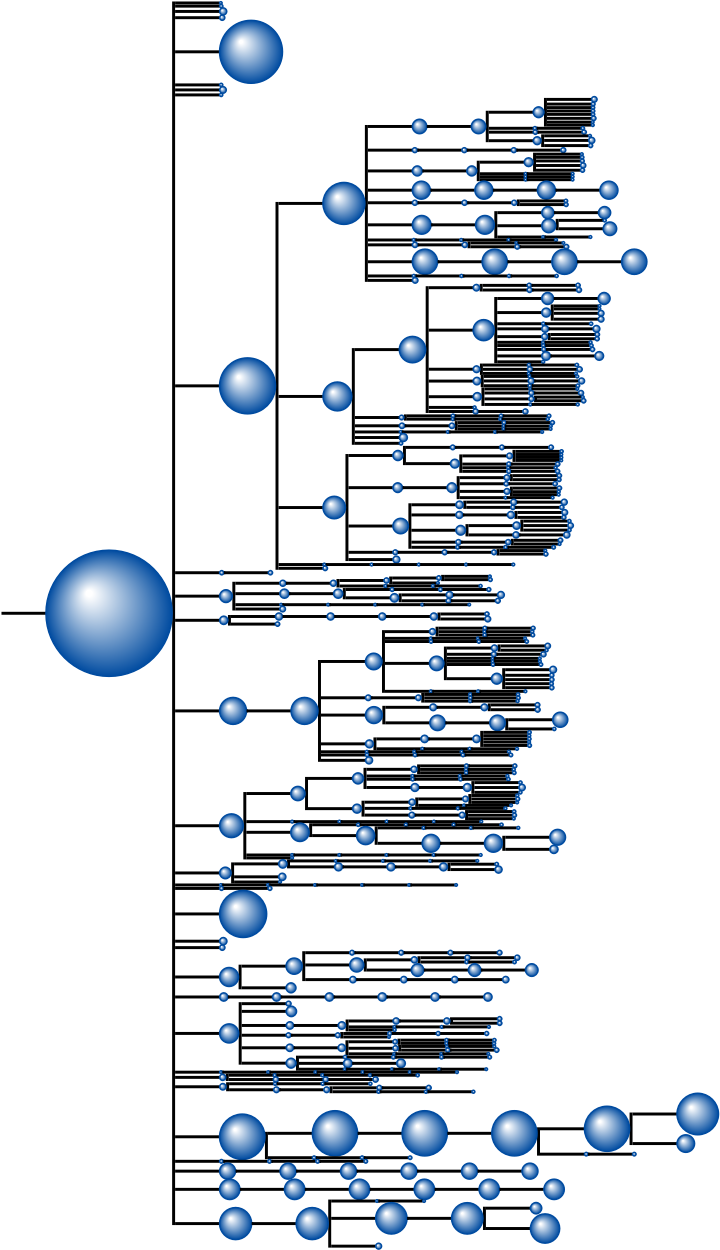

In [160]:
os.makedirs("figures/sfigures/sfigure6/panel_B/", exist_ok=True)

ts_l = TreeStyle()
ts_l.layout_fn = lambda x: layout(x, label=True, color=dark_blue)
ts_l.show_leaf_name = False
ts_l.show_scale = False
ts_l.mode = "r"
#ts_l.branch_vertical_margin = 1

ts = TreeStyle()
ts.layout_fn = lambda x: layout(x, label=False, color=dark_blue)
ts.show_leaf_name = False
ts.show_scale = False
ts.mode = "r"

tree.render("figures/sfigures/sfigure6/panel_B/rna_tree.svg", tree_style=ts, units='in', w=8)
tree.render("%%inline", tree_style=ts, units='in', w=8)

In [161]:
# DNA
x = dna_samples.loc[dna_samples.index.difference(bad_dna)]

d = x.copy()
d["taxid"] = ia.loc[d.index, "taxid"]
d = d.groupby(by="taxid").sum()

In [162]:
counts = 100*d.sum(axis=1)/x.sum().sum()
counts.sort_values(ascending=False, inplace=True)
taxids = counts.index[:66] # 70% of reads

In [163]:
[(t, counts.loc[t], ncbi.get_taxid_translator([int(t)])[int(t)]) for t in counts.index[:10]]

[('615', 18.91572428399933, 'Serratia marcescens'),
 ('1758196', 12.865407149293713, 'Serratia sp. SSNIH1'),
 ('368607', 6.779106732974321, 'Janthinobacterium svalbardensis'),
 ('2590869', 6.507643115557592, 'Janthinobacterium tructae'),
 ('294', 2.3683355323116544, 'Pseudomonas fluorescens'),
 ('55508', 1.573320293238116, 'Janthinobacterium agaricidamnosum'),
 ('2478662', 1.3155938830471585, 'Acidovorax sp. 1608163'),
 ('1334564', 1.196982325135091, 'Serratia marcescens SM39'),
 ('273526', 1.1416234303446706, 'Serratia marcescens subsp. marcescens Db11'),
 ('1938606', 1.0456680127079419, 'Janthinobacterium sp. LM6')]

In [164]:
tree = pruned_contaminant_tree(taxids, counts*100)

## Panel A

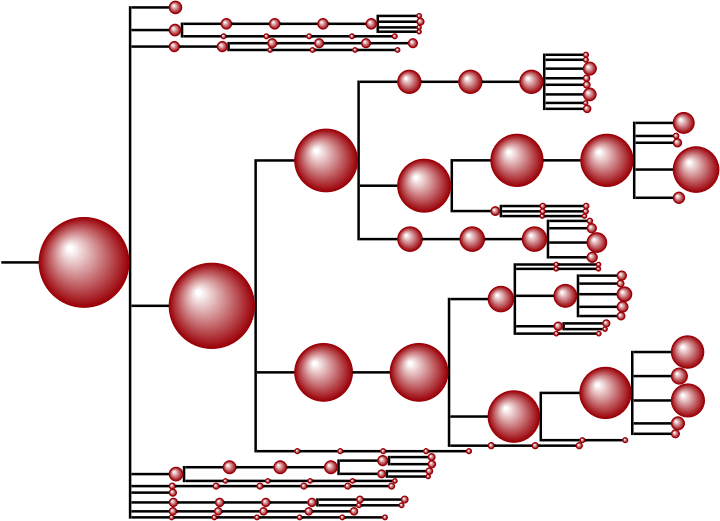

In [165]:
os.makedirs("figures/sfigures/sfigure6/panel_A/", exist_ok=True)
ts_l = TreeStyle()
ts_l.layout_fn = lambda x: layout(x, label=True, color=dark_red)
ts_l.show_leaf_name = False
ts_l.show_scale = False
ts_l.mode = "r"
#ts_l.branch_vertical_margin = 1

ts = TreeStyle()
ts.layout_fn = lambda x: layout(x, label=False, color=dark_red)
ts.show_leaf_name = False
ts.show_scale = False
ts.mode = "r"

tree.render("figures/sfigures/sfigure6/panel_A/dna_tree.svg", tree_style=ts, units='in', w=8)
tree.render("%%inline", tree_style=ts, units='in', w=8)
#plt.savefig('figures/sfigures/dna_tree.svg')


# Figure S7 - Differential infectome analysis - DE dynamics

In [167]:
de = pd.read_table("tables/rna_genus_bNAbs.de.txt", index_col=0)
de["-logP"] = -np.log10(de["FDR"])

In [168]:
u = de.query("FDR < 0.05").query("logFC > 0").index
d = de.query("FDR < 0.05").query("logFC < 0").index

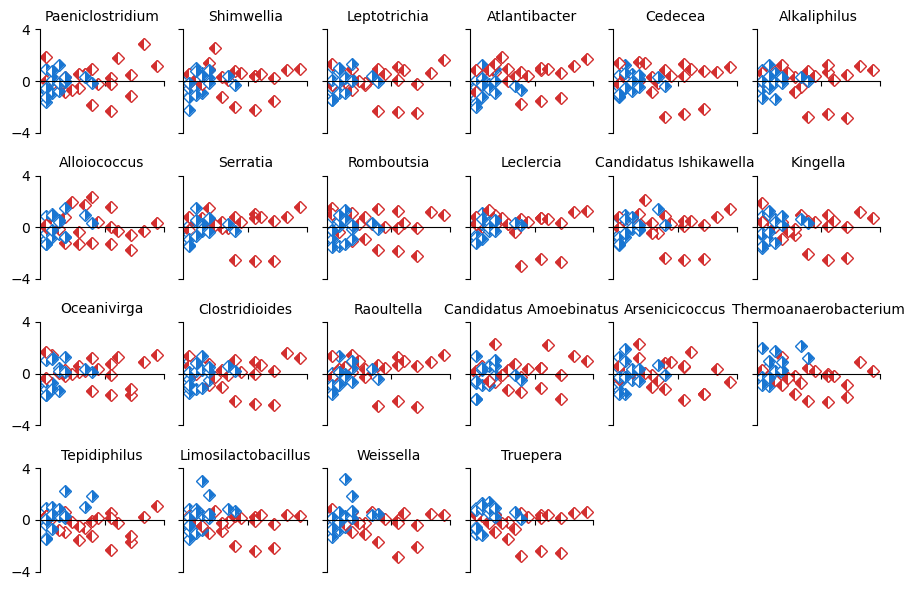

In [172]:
x = pd.read_table("tables/just_rna_counts_genus.txt", index_col=0)

os.makedirs("figures/sfigures/sfigure7/", exist_ok=True)
x = np.log10(x+1)

x = x.loc[list(u) + list(d)]
x = x.sub(x.mean(axis=1), axis=0)
x = x.div(x.std(axis=1), axis=0)
#x.index = ensembl.loc[x.index, "Gene name"]

f, axarr = plt.subplots(nrows=4, ncols=6, sharex=True, sharey=True, figsize=(1.5*6, 1.5*4))
axarr = axarr.flatten()

for i, g in enumerate(x.index):
    for s in x.columns:
        if design.loc[s, "bNAbs"] == "Y":
            color=red
            fillstyle="left"
        else:
            color=blue
            fillstyle="right"
        axarr[i].plot(100*breadth_metadata.loc[s, "% breadth"], x.loc[g, s], color=color, marker="D", 
                 markerfacecoloralt="white", linewidth=0, markeredgewidth=0, fillstyle=fillstyle)
        axarr[i].plot(100*breadth_metadata.loc[s, "% breadth"], x.loc[g, s], color=color, marker="D", 
                 markerfacecoloralt="white", linewidth=0, markeredgewidth=1, fillstyle="none")
    title = ncbi.get_taxid_translator([int(g)])[int(g)]
    axarr[i].set_title("{}".format(title), fontsize=10)
    axarr[i].set_ylim(-4, 4)
    axarr[i].set_yticks([-4, 0, 4])
    axarr[i].set_xticks([50, 100])
    axarr[i].set_xticklabels(["", ""])
    axarr[i].spines['bottom'].set_position('center')
    sns.despine(ax=axarr[i])
    
axarr[-1].axis('off')
axarr[-2].axis('off')
plt.tight_layout()
plt.savefig("figures/sfigures/sfigure7/S7_raw.svg")
plt.show()